In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import math 

In [27]:
data = pd.read_csv('all_stocks_5yr.csv')

In [28]:
data

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [29]:
stocks = set(data['Name'])

stock_dict = {}
for stock in stocks:
    stock_dict[stock] = []

In [31]:
for i, row in data.iterrows():
    if '2018' in row['date']:
        stock_dict[row['Name']].append(dict(row))

In [8]:
# now build the correlation network 

In [33]:
def mean(stock_i):
    mean = 0
    for item in stock_dict[stock_i]:
        mean += item['close']
    return mean/len(stock_dict[stock_i])
        

In [34]:
def cross_correlation(stock_i, stock_j):
    cross_c = 0
    numerator = 0
    denom_i = 0 
    denom_j = 0
    mean_i = mean(stock_i)
    mean_j = mean(stock_j)
    
    for item_i in stock_dict[stock_i]:
        for item_j in stock_dict[stock_j]:
            if item_i['date'] == item_j['date']:
                numerator += (item_i['close'] - mean_i) * (item_j['close'] - mean_j)
                denom_i += (item_i['close'] - mean_i)**2
                denom_j += (item_j['close'] - mean_j)**2
                
    
    return numerator/(math.sqrt(denom_i) * math.sqrt(denom_j))
                

In [35]:
def create_correlation_matrix():
    lst = []
    for i in stock_dict.keys():
        sub_lst = []
        for j in stock_dict.keys():
            sub_lst.append(cross_correlation(i, j))
        lst.append(sub_lst)
    return lst 

In [36]:
correlation_matrix = create_correlation_matrix()

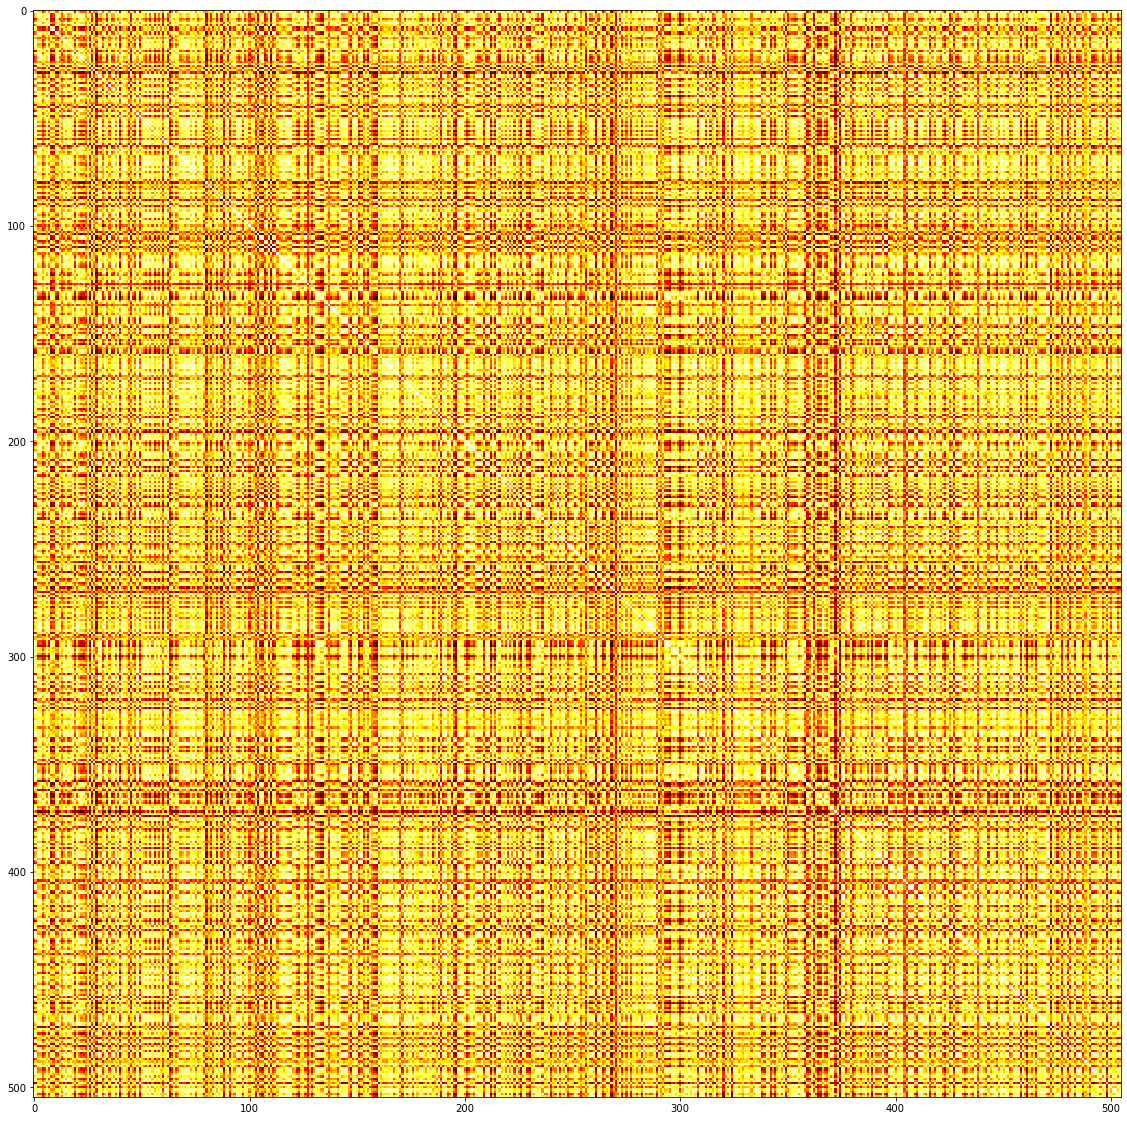

In [51]:
plt.figure(figsize=(20, 20))
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.show()

In [53]:
np.mean(correlation_matrix)

0.3824780648891503

In [77]:
theta = .9
def adj_matrix(correlation_matrix):
    lst = []
    for row_index in range(len(correlation_matrix)):
        sub_lst = []
        for col_index in range(len(correlation_matrix[row_index])):
            if row_index != col_index and abs(correlation_matrix[row_index][col_index]) > theta:
                sub_lst.append(1)
            else:
                sub_lst.append(0)
        lst.append(sub_lst)
    return lst

In [82]:
def create_correlation_network():
    g = nx.Graph()
    for key in stock_dict.keys():
        g.add_node(key)
        
    adj_list = adj_matrix(create_correlation_matrix())
    dict_keys = list(stock_dict.keys())
    
    for row_index in range(len(adj_list)):
        for col_index in range(len(adj_list[row_index])):
            if adj_list[row_index][col_index]:
                g.add_edge(dict_keys[row_index], dict_keys[col_index])
    return g
    

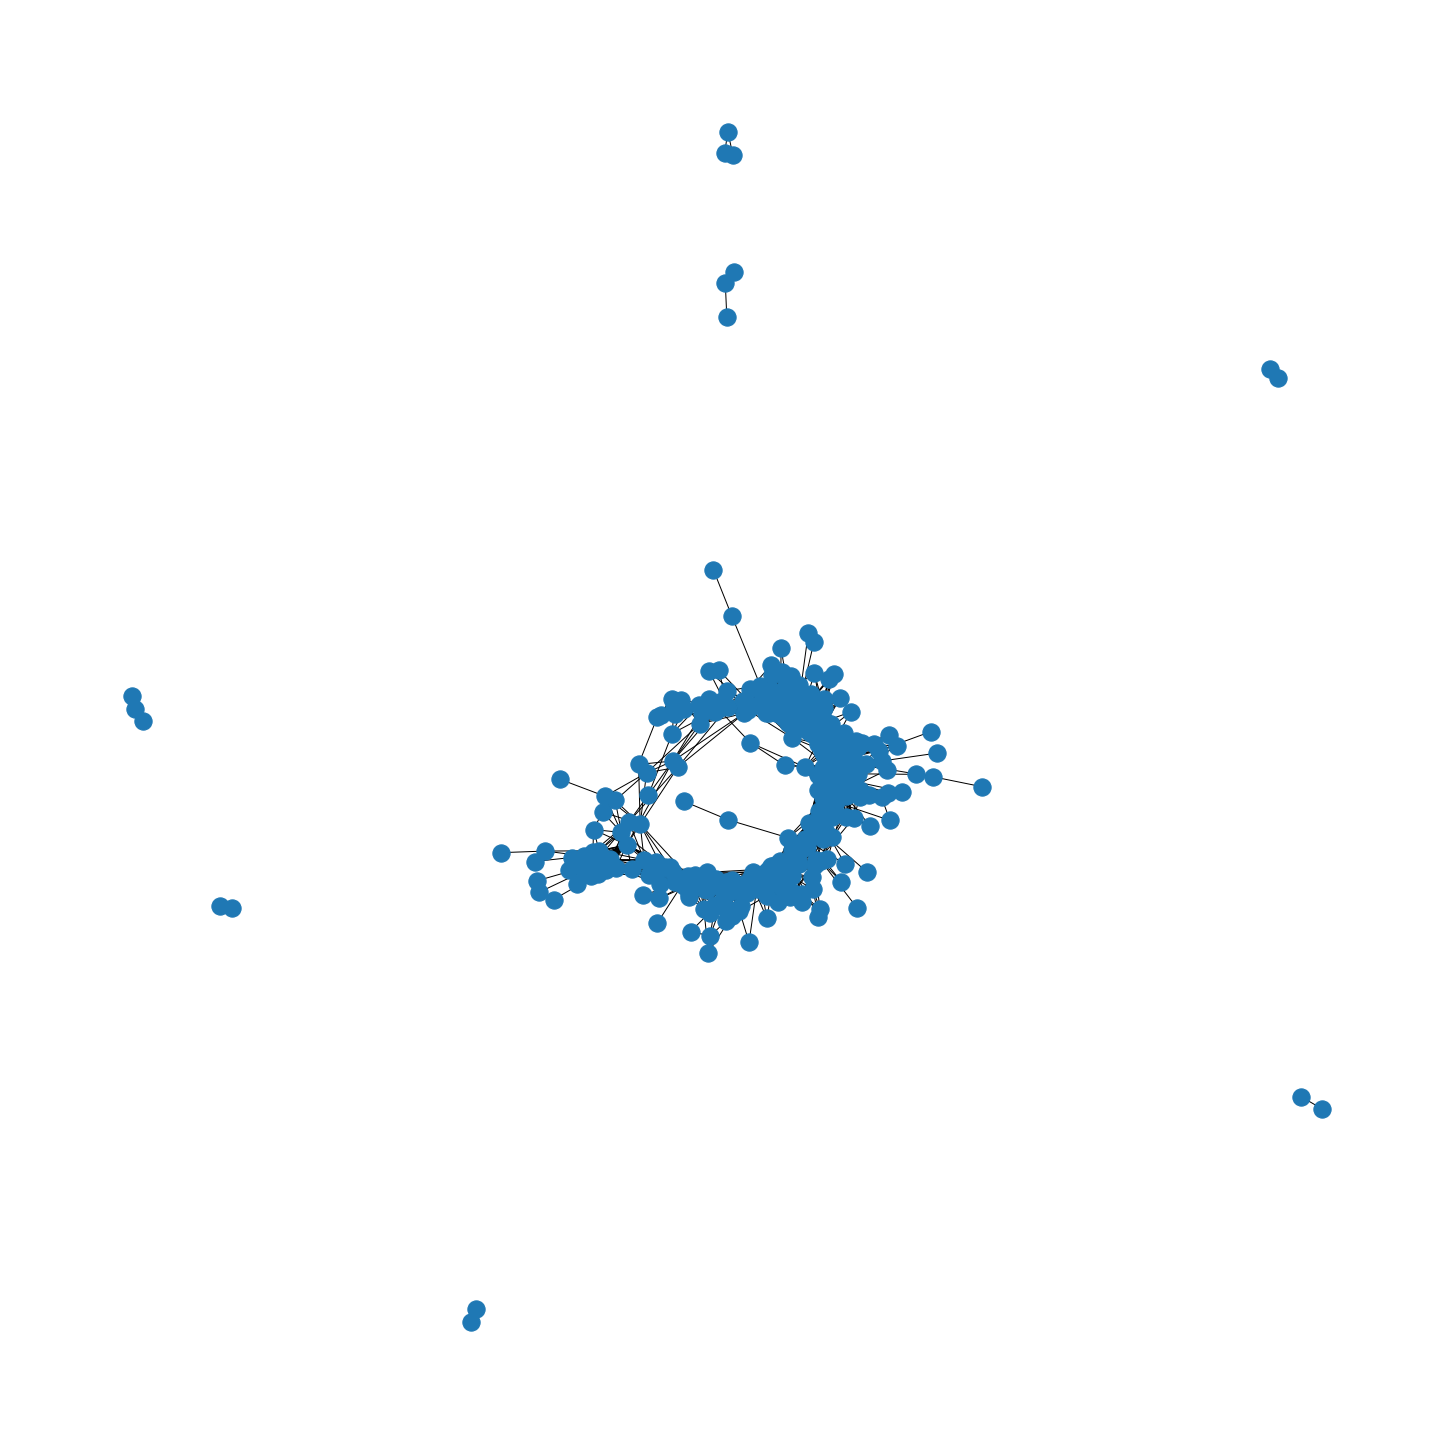

In [81]:
g = create_correlation_network()

plt.figure(figsize=(20, 20))
nx.draw_spring(g)

In [68]:
len(g)

505